In [65]:
import time
import datetime
from IPython.display import display, clear_output
import connect as ibc
import asyncio
import pandas as pd
from ib_insync import *

import numpy as np
util.startLoop()  # uncomment this line when in a notebook

In [153]:
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

In [171]:
ib.disconnect()

In [162]:
start = ''
end = datetime.datetime.now()
ticks = ib.reqHistoricalTicks(Forex('EURUSD'), start, end, 1000, 'BID_ASK', useRth=False)

In [163]:
df = []

In [164]:
for tick in ticks:
    df.append([tick.time, tick.sizeBid, tick.priceBid, tick.priceAsk, tick.sizeAsk])

In [165]:
df = pd.DataFrame(df)
df.columns = ['time', 'bidSize', 'bid', 'ask', 'askSize']

<AxesSubplot:>

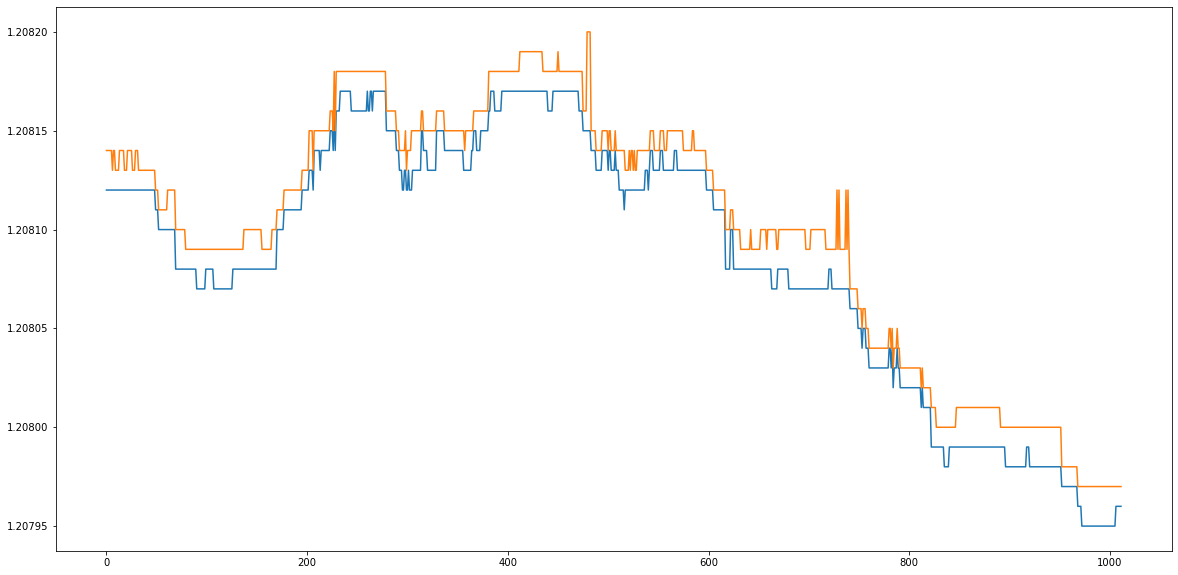

In [167]:
df.bid.plot(figsize=(20,10))
df.ask.plot()

In [131]:
contracts = [Stock(pair) for pair in (secIdType='ISIN', secId='IT0003856405')]
ib.qualifyContracts(*contracts)

eurusd = contracts[0]

SyntaxError: invalid syntax (<ipython-input-131-22bdb52ef960>, line 1)

In [132]:
LDO = Stock(secIdType='ISIN', secId='IT0003856405')
ldo = Stock('LDO', 'SMART', 'EUR')
cds = ib.reqContractDetails(ldo)

In [137]:
cds

[ContractDetails(contract=Contract(secType='STK', conId=35162453, symbol='LDO', exchange='SMART', primaryExchange='BVME', currency='EUR', localSymbol='LDO', tradingClass='LDO'), marketName='LDO', minTick=0.0001, orderTypes='ACTIVETIM,AD,ADJUST,ALERT,ALGO,ALGOLTH,ALLOC,AUC,AVGCOST,BASKET,BENCHPX,CASHQTY,COND,CONDORDER,DAY,DEACT,DEACTDIS,DEACTEOD,GAT,GTC,GTD,GTT,HID,IOC,LIT,LMT,LTH,MIT,MKT,MKT2BBO,MOC,MTL,NGCOMB,NODARK,NONALGO,OCA,OPG,PEGBENCH,SCALE,SCALERST,SIZECHK,SNAPMID,SNAPMKT,SNAPREL,STP,STPLMT,TRAIL,TRAILLIT,TRAILLMT,TRAILMIT,WHATIF', validExchanges='SMART,FWB,BVME,SWB,TGATE,GETTEX', priceMagnifier=1, underConId=0, longName='LEONARDO SPA', contractMonth='', industry='Industrial', category='Aerospace/Defense', subcategory='Aerospace/Defense', timeZoneId='MET', tradingHours='20210428:0900-20210428:1742;20210429:0900-20210429:1742;20210430:0900-20210430:1742;20210501:CLOSED;20210502:CLOSED;20210503:0900-20210503:1742', liquidHours='20210428:0900-20210428:1730;20210429:0900-20210429:1

In [39]:
contracts = [cd.contract for cd in cds]
util.df(contracts)

,secType,conId,symbol,lastTradeDateOrContractMonth,strike,right,multiplier,exchange,primaryExchange,currency,localSymbol,tradingClass,includeExpired,secIdType,secId,comboLegsDescrip,comboLegs,deltaNeutralContract
0,STK,35162453,LDO,,0.0,,,SMART,BVME,EUR,LDO,LDO,False,,,,[],None


In [45]:
ib.qualifyContracts(eurusd)

[Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')]

In [21]:
eurusd = Forex('EURUSD')
ib.reqMktData(eurusd, '', False, False)
ticker = ib.ticker(eurusd)

In [57]:
def on_new_tick(tickers):
    for t in tickers:
        print(t.ask, t.bid)
        clear_output(wait=True)

In [27]:
ib.run()

In [58]:
ib.pendingTickersEvent += on_new_tick
ib.sleep(30)
ib.pendingTickersEvent -= on_new_tick

1.20891 1.2089
1.20891 1.2089
1.20891 1.2089


In [4]:
df = pd.DataFrame(
    index=[eurusd.pair()],
    columns=['bidSize', 'bid', 'ask', 'askSize', 'high', 'low', 'close'])

def onPendingTickers(tickers):
        df.loc[eurusd.pair()] = (
            t.bidSize, t.bid, t.ask, t.askSize, t.high, t.low, t.close)
        clear_output(wait=True)
    display(df)        

ib.pendingTickersEvent += onPendingTickers
ib.sleep(30)
ib.pendingTickersEvent -= onPendingTickers

,bidSize,bid,ask,askSize,high,low,close
EURUSD,8500000,1.20869,1.20873,5000000,1.2117,1.20615,1.2098


In [24]:
for contract in contracts:
    ib.reqMktData(contract, '', False, False)

In [25]:
ticker = ib.ticker(eurusd)
ib.sleep(2)

ticker.marketPrice()

nan

In [76]:
ib = ibc.ib_connect(client_id=1)
ib.open_connection()

In [87]:
ib.close_connection()

In [77]:
data = np.array([0,0,0,0])

In [78]:
def process_ticks(tick):
    global data
    data = np.append(data, (tick.askSize, tick.ask, tick.bid, tick.bidSize))
    

def new_tick(tickers):
    for ticker in tickers:
        process_ticks(ticker)

In [173]:
data[4:]

array([6.00000e+06, 1.20965e+00, 1.20963e+00, ..., 1.20935e+00,
       1.20934e+00, 9.50000e+06])

In [169]:
data[-2]

1.20934

In [170]:
data[-3]

1.20935

In [79]:
ib.start_stream('EURUSD', new_tick)

KeyboardInterrupt: 

In [18]:
try:
    ib.sleep(30)
except (KeyboardInterrupt, SystemExit):
    ib.close_connection()

AttributeError: 'ib_connect' object has no attribute 'sleep'

In [ ]:
try:
    ib.start_stream('EURUSD')

In [4]:

try:
    asyncio.run(ib.start_stream('EURUSD'))
except (KeyboardInterrupt, SystemExit):
    ib.close_connection()

Ticker(contract=Forex('EURUSD', exchange='IDEALPRO'), time=datetime.datetime(2021, 4, 26, 17, 11, 24, 421750, tzinfo=datetime.timezone.utc), bid=1.20867, bidSize=2000000, ask=1.20868, askSize=2000000, high=1.2117, low=1.20615, close=1.2098, halted=0.0, ticks=[TickData(time=datetime.datetime(2021, 4, 26, 17, 11, 24, 421750, tzinfo=datetime.timezone.utc), tickType=1, price=1.20867, size=2000000), TickData(time=datetime.datetime(2021, 4, 26, 17, 11, 24, 421750, tzinfo=datetime.timezone.utc), tickType=2, price=1.20868, size=2000000), TickData(time=datetime.datetime(2021, 4, 26, 17, 11, 24, 421750, tzinfo=datetime.timezone.utc), tickType=6, price=1.2117, size=0), TickData(time=datetime.datetime(2021, 4, 26, 17, 11, 24, 421750, tzinfo=datetime.timezone.utc), tickType=7, price=1.20615, size=0), TickData(time=datetime.datetime(2021, 4, 26, 17, 11, 24, 421750, tzinfo=datetime.timezone.utc), tickType=9, price=1.2098, size=0), TickData(time=datetime.datetime(2021, 4, 26, 17, 11, 24, 421750, tzinf